# Case study: Aecert Robotics gaits gen

Aecert Robotics youtube channel covers a hexapod build and it mentions a new gait generation algorithm that allows on the fly transitions https://youtu.be/DKsyJYkdZ_o?si=0ym37QSEdOcEfFBf

With some google search it looks like code is here https://github.com/Ryan-Mirch/Aecerts_Hexapod_V1/blob/main/RC_V3/RC%20Code/src/Pages/GaitsPage.cpp

There is no license attached in the repo, which means now work can be reproduced, distributed or any derivative work can be created... according to https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/licensing-a-repository code in public repo can be forked and viewed

This notebook is just a case study of the code in original repo and is not a derivative work. All copyright to the code still belongs to 

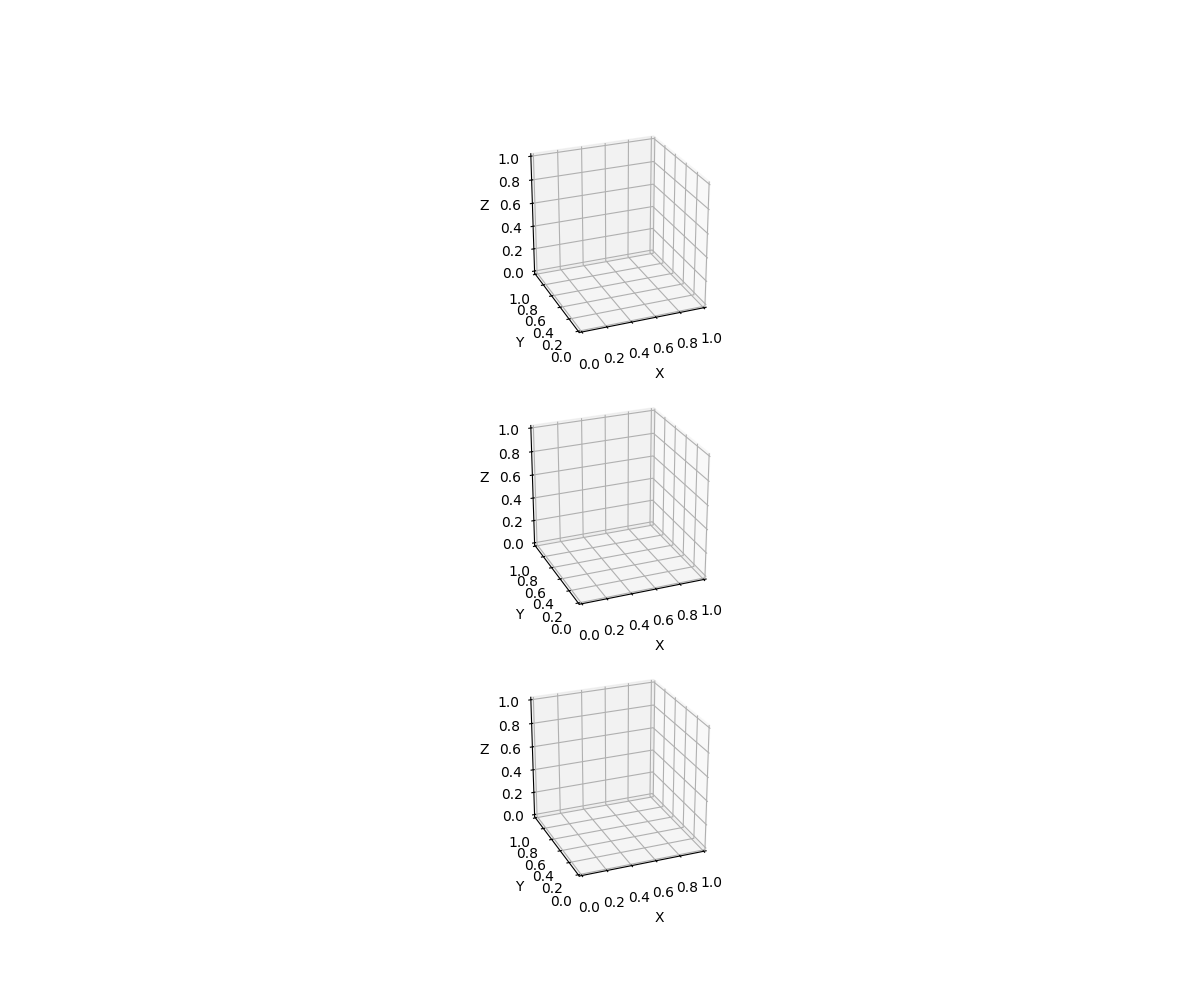

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

class GaitGen:
    def __init__(self):
        pass


%matplotlib widget

fig, axes = plt.subplots(
    3,
    1,
    figsize=(12, 10),
    subplot_kw={
        'projection': '3d',
        'aspect': 'equal',
        # 'xlim': (0, 128),
        # 'ylim': (0, 64),
        'xlabel': 'X',
        'ylabel': 'Y',
        'zlabel': 'Z',

        'elev': 25,
        'azim': -112,
    },
)

gait = GaitGen()